In [1]:
print("Importing packages")

import os
import pickle
import numpy as np
import random

from osl_dynamics.simulation import HMM_MVN, MDyn_HMM_MVN
# from osl_dynamics import simulation
from osl_dynamics.data import Data
from osl_dynamics.models.hmm import Config, Model
from osl_dynamics.inference import modes, metrics
from osl_dynamics.utils import plotting


Importing packages


2025-03-11 17:00:54.377708: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-11 17:00:54.687828: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 17:00:54.699446: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-11 17:00:54.699662: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [ ]:
"""Example script for running HMM inference on simulated HMM-MVN data.

This script should take less than a couple minutes to run and
achieve a dice coefficient of ~0.99.
"""

# Set random seed
random.seed(15)

# Create directory for results
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

#%% Simulate data
n_states = 5
n_channels = 11

print("Simulating data")
sim = HMM_MVN(
    n_samples=25600,
    n_states=n_states,
    n_channels=n_channels,
    trans_prob="sequence",
    stay_prob=0.9,
    means="zero",
    covariances="random",
)

# Create Data object for training
data = Data(sim.time_series)

# Prepare data
data.standardize()

#%% Build model

config = Config(
    n_states=n_states,
    n_channels=n_channels,
    sequence_length=200,
    learn_means=False,
    learn_covariances=True,
    batch_size=16,
    learning_rate=0.01,
    n_epochs=20,
)

model = Model(config)
model.summary()

#%% Train model

# Initialization
init_history = model.random_state_time_course_initialization(data, n_init=3, n_epochs=1)

# Full training
history = model.fit(data)

# Calculate the free energy
free_energy = model.free_energy(data)
history["free_energy"] = free_energy


#%% Get inferred parameters

# Inferred state probabilities
alp = model.get_alpha(data)

# Observation model parameters
means, covs = model.get_means_covariances()

# Viterbi path
stc = modes.argmax_time_courses(alp)

#%% Compare inferred parameters to ground truth simulation

# Re-order simulated state time courses to match inferred
inf_stc, sim_stc = modes.match_modes(stc, sim.state_time_course)

# Calculate dice coefficient
dice = metrics.dice_coefficient(inf_stc, sim_stc)

print("Dice coefficient:", dice)

#%% Delete temporary directory

data.delete_dir()

Simulating data


Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Standardize:   0%|          | 0/1 [00:00<?, ?it/s]

Model: "HMM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 200, 16)]    0           []                               
                                                                                                  
 tf.split_7 (TFOpLambda)        [(None, 200, 11),    0           ['inputs[0][0]']                 
                                 (None, 200, 5)]                                                  
                                                                                                  
 static_loss_scaling_factor (St  ()                  0           ['tf.split_7[0][0]']             
 aticLossScalingFactorLayer)                                                                      
                                                                                                

2025-03-11 14:42:14 INFO osl-dynamics [hmm.py:485:random_state_time_course_initialization]: Random state time course initialization
2025-03-11 14:42:14 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 0
2025-03-11 14:42:14 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
8/8 [==============================] - 5s 153ms/step - rho: 0.2853 - lr: 0.0100 - loss: 14.5350


2025-03-11 14:42:19 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 1
2025-03-11 14:42:19 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
8/8 [==============================] - 3s 152ms/step - rho: 0.2853 - lr: 0.0100 - loss: 14.5471


2025-03-11 14:42:22 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 2
2025-03-11 14:42:22 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
8/8 [==============================] - 3s 159ms/step - rho: 0.2853 - lr: 0.0100 - loss: 14.4468


2025-03-11 14:42:26 INFO osl-dynamics [hmm.py:522:random_state_time_course_initialization]: Using initialization 2


Epoch 1/20
8/8 [==============================] - 1s 150ms/step - rho: 0.2853 - lr: 0.0100 - loss: 13.6070
Epoch 2/20
8/8 [==============================] - 1s 145ms/step - rho: 0.1866 - lr: 0.0090 - loss: 12.9702
Epoch 3/20
8/8 [==============================] - 1s 148ms/step - rho: 0.1436 - lr: 0.0082 - loss: 12.4830
Epoch 4/20
8/8 [==============================] - 1s 149ms/step - rho: 0.1187 - lr: 0.0074 - loss: 12.0895
Epoch 5/20
8/8 [==============================] - 1s 149ms/step - rho: 0.1022 - lr: 0.0067 - loss: 11.7686
Epoch 6/20
8/8 [==============================] - 1s 175ms/step - rho: 0.0904 - lr: 0.0061 - loss: 11.5024
Epoch 7/20
8/8 [==============================] - 1s 150ms/step - rho: 0.0814 - lr: 0.0055 - loss: 11.2880
Epoch 8/20
8/8 [==============================] - 1s 154ms/step - rho: 0.0743 - lr: 0.0050 - loss: 11.1166
Epoch 9/20
8/8 [==============================] - 1s 151ms/step - rho: 0.0686 - lr: 0.0045 - loss: 10.9768
Epoch 10/20
8/8 [====================

2025-03-11 14:42:51 INFO osl-dynamics [hmm.py:1118:free_energy]: Getting free energy
2025-03-11 14:42:52 INFO osl-dynamics [hmm.py:1311:get_alpha]: Getting alpha


Dice coefficient: 0.9987109375


Dice coefficient: 0.9987109375


(<Figure size 1200x250 with 2 Axes>,
 [<Axes: title={'center': 'Inferred $\\alpha$'}, xlabel='Sample', ylabel='$\\alpha_{jt}$'>])

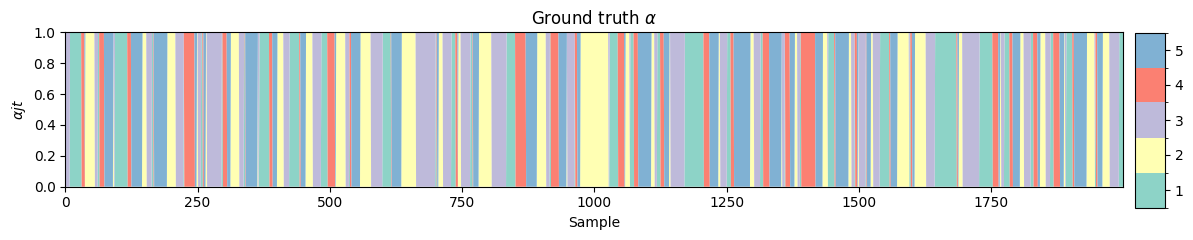

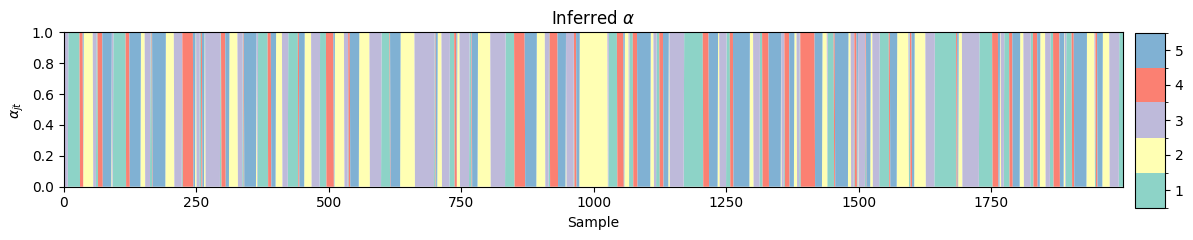

In [25]:
print("Dice coefficient:", dice)

plotting.plot_alpha(
    inf_stc,
    n_samples=2000,
    title="Ground truth " + r"$\alpha$",
    y_labels=r"$\alpha{jt}$",
    # filename="figures_BG/sim_beta.png",
)

plotting.plot_alpha(
    sim_stc,
    n_samples=2000,
    title="Inferred " + r"$\alpha$",
    y_labels=r"$\alpha_{jt}$",
    # filename="figures_BG/inf_beta.png",
)



In [51]:
"""Example script for running HMM inference on simulated HMM-MVN data.

This script should take less than a couple minutes to run and
achieve a dice coefficient of ~0.99.
"""

# Set random seed
random.seed(63)

# Create directory for results
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

#%% Simulate data
n_states = 5
n_channels = 11

print("Simulating data")
# sim = HMM_MVN(
#     n_samples=25600,
#     n_states=n_states,
#     n_channels=n_channels,
#     trans_prob="sequence",
#     stay_prob=0.9,
#     means="zero",
#     covariances="random",
# )

sim = MDyn_HMM_MVN(
    n_samples=25600,
    n_modes=n_states,
    n_channels=n_channels,
    trans_prob="sequence",
    stay_prob=0.9,
    means="random",
    covariances="random",
)

# sim_alpha = time series made by time-varying means only
# sim_beta = time series made by time-varying correlations only
# sim_gamma = time series made by time-varying variances only
sim_alpha_stc, sim_beta_stc, sim_gamma_stc = sim.mode_time_course
sim_alpha_time_series = sim.time_series_alpha
sim_beta_time_series = sim.time_series_beta
sim_gamma_time_series = sim.time_series_gamma

# Create Data object for training
data_alpha = Data(sim_alpha_time_series)
data_beta = Data(sim_beta_time_series)
data_gamma = Data(sim_gamma_time_series)

# Prepare data
data.standardize()

#%% Build model

# config = Config(
#     n_states=5,
#     n_channels=11,
#     sequence_length=200,
#     learn_means=False,
#     learn_covariances=True,
#     batch_size=16,
#     learning_rate=0.01,
#     n_epochs=20,
# )

config_alpha = Config(
    n_states=n_states,
    n_channels=n_channels,
    sequence_length=400,
    learn_means=True,
    learn_covariances=False,
    learn_trans_prob=True,
    # initial_trans_prob=initial_trans_prob,
    batch_size=16,
    learning_rate=0.01,
    n_epochs=20,
)

config_beta = Config(
    n_states=n_states,
    n_channels=n_channels,
    sequence_length=400,
    learn_means=False,
    learn_covariances=True,
    learn_trans_prob=True,
    # initial_trans_prob=initial_trans_prob,
    batch_size=16,
    learning_rate=0.01,
    n_epochs=20,
)

config_gamma = Config(
    n_states=n_states,
    n_channels=n_channels,
    sequence_length=400,
    learn_means=False,
    learn_covariances=True,
    diagonal_covariances=True,
    learn_trans_prob=True,
    # initial_trans_prob=initial_trans_prob,
    batch_size=16,
    learning_rate=0.01,
    n_epochs=20,
)

model_alpha = Model(config_alpha)
model_beta = Model(config_beta)
model_gamma = Model(config_gamma)
# model.summary()

#%% Train model

# Initialization
init_history_alpha = model_alpha.random_state_time_course_initialization(data_alpha, n_init=3, n_epochs=1)
init_history_beta = model_beta.random_state_time_course_initialization(data_beta, n_init=3, n_epochs=1)
init_history_gamma = model_gamma.random_state_time_course_initialization(data_gamma, n_init=3, n_epochs=1)

# Full training
history_alpha = model_alpha.fit(data_alpha)
history_beta = model_beta.fit(data_beta)
history_gamma = model_gamma.fit(data_gamma)

# Calculate the free energy
free_energy_alpha = model_alpha.free_energy(data_alpha)
free_energy_beta = model_beta.free_energy(data_beta)
free_energy_gamma = model_gamma.free_energy(data_gamma)

#%% Get inferred parameters

# Inferred state probabilities
alp_alpha = model_alpha.get_alpha(data_alpha)
alp_beta = model_beta.get_alpha(data_beta)
alp_gamma = model_gamma.get_alpha(data_gamma)

# Observation model parameters
means_alpha, covs_alpha = model_alpha.get_means_covariances()
means_beta, covs_beta = model_beta.get_means_covariances()
means_gamma, covs_gamma = model_gamma.get_means_covariances()

# Viterbi path
stc_alpha = modes.argmax_time_courses(alp_alpha)
stc_beta = modes.argmax_time_courses(alp_beta)
stc_gamma = modes.argmax_time_courses(alp_gamma)

#%% Compare inferred parameters to ground truth simulation

# Re-order simulated state time courses to match inferred
inf_stc_alpha, sim_stc_alpha = modes.match_modes(stc_alpha, sim_alpha_stc)
inf_stc_beta, sim_stc_beta = modes.match_modes(stc_beta, sim_beta_stc)
inf_stc_gamma, sim_stc_gamma = modes.match_modes(stc_gamma, sim_gamma_stc)

# Calculate dice coefficient
dice_alpha = metrics.dice_coefficient(inf_stc_alpha, sim_stc_alpha)
dice_beta = metrics.dice_coefficient(inf_stc_beta, sim_stc_beta)
dice_gamma = metrics.dice_coefficient(inf_stc_gamma, sim_stc_gamma)

print("Dice coefficient (Alpha):", dice_alpha)
print("Dice coefficient (Beta):", dice_beta)
print("Dice coefficient (gamma):", dice_gamma)

#%% Delete temporary directory

data.delete_dir()

Simulating data


Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Standardize:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-11 15:40:26 INFO osl-dynamics [hmm.py:485:random_state_time_course_initialization]: Random state time course initialization
2025-03-11 15:40:26 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 0
2025-03-11 15:40:26 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 3s 182ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.7801


2025-03-11 15:40:29 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 1
2025-03-11 15:40:29 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 4s 185ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.7799


2025-03-11 15:40:33 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 2
2025-03-11 15:40:33 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 2s 172ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.7819


2025-03-11 15:40:35 INFO osl-dynamics [hmm.py:522:random_state_time_course_initialization]: Using initialization 1
2025-03-11 15:40:35 INFO osl-dynamics [hmm.py:485:random_state_time_course_initialization]: Random state time course initialization
2025-03-11 15:40:35 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 0
2025-03-11 15:40:35 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 4s 210ms/step - rho: 0.2853 - lr: 0.0100 - loss: 14.6513


2025-03-11 15:40:39 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 1
2025-03-11 15:40:39 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 3s 169ms/step - rho: 0.2853 - lr: 0.0100 - loss: 14.6381


2025-03-11 15:40:42 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 2
2025-03-11 15:40:42 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 3s 198ms/step - rho: 0.2853 - lr: 0.0100 - loss: 14.6290


2025-03-11 15:40:45 INFO osl-dynamics [hmm.py:522:random_state_time_course_initialization]: Using initialization 2
2025-03-11 15:40:45 INFO osl-dynamics [hmm.py:485:random_state_time_course_initialization]: Random state time course initialization
2025-03-11 15:40:45 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 0
2025-03-11 15:40:45 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 3s 158ms/step - rho: 0.2853 - lr: 0.0100 - loss: 4.6535


2025-03-11 15:40:48 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 1
2025-03-11 15:40:48 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 4s 231ms/step - rho: 0.2853 - lr: 0.0100 - loss: 4.6374


2025-03-11 15:40:53 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 2
2025-03-11 15:40:53 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 5s 818ms/step - rho: 0.2853 - lr: 0.0100 - loss: 4.6474


2025-03-11 15:40:57 INFO osl-dynamics [hmm.py:522:random_state_time_course_initialization]: Using initialization 1


Epoch 1/20
4/4 [==============================] - 1s 230ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.7674
Epoch 2/20
4/4 [==============================] - 1s 221ms/step - rho: 0.1866 - lr: 0.0090 - loss: 15.7494
Epoch 3/20
4/4 [==============================] - 1s 161ms/step - rho: 0.1436 - lr: 0.0082 - loss: 15.7267
Epoch 4/20
4/4 [==============================] - 1s 155ms/step - rho: 0.1187 - lr: 0.0074 - loss: 15.7044
Epoch 5/20
4/4 [==============================] - 1s 155ms/step - rho: 0.1022 - lr: 0.0067 - loss: 15.6850
Epoch 6/20
4/4 [==============================] - 1s 181ms/step - rho: 0.0904 - lr: 0.0061 - loss: 15.6690
Epoch 7/20
4/4 [==============================] - 1s 181ms/step - rho: 0.0814 - lr: 0.0055 - loss: 15.6561
Epoch 8/20
4/4 [==============================] - 1s 184ms/step - rho: 0.0743 - lr: 0.0050 - loss: 15.6461
Epoch 9/20
4/4 [==============================] - 1s 254ms/step - rho: 0.0686 - lr: 0.0045 - loss: 15.6390
Epoch 10/20
4/4 [====================

2025-03-11 15:41:43 INFO osl-dynamics [hmm.py:1118:free_energy]: Getting free energy
2025-03-11 15:41:43 INFO osl-dynamics [hmm.py:1118:free_energy]: Getting free energy
2025-03-11 15:41:44 INFO osl-dynamics [hmm.py:1118:free_energy]: Getting free energy
2025-03-11 15:41:44 INFO osl-dynamics [hmm.py:1311:get_alpha]: Getting alpha
2025-03-11 15:41:45 INFO osl-dynamics [hmm.py:1311:get_alpha]: Getting alpha
2025-03-11 15:41:45 INFO osl-dynamics [hmm.py:1311:get_alpha]: Getting alpha


Dice coefficient (Alpha): 0.618125
Dice coefficient (Beta): 0.997265625
Dice coefficient (gamma): 0.5314453125


Dice coefficient (Alpha): 0.618125
Dice coefficient (Beta): 0.997265625
Dice coefficient (gamma): 0.5314453125


(<Figure size 1200x250 with 2 Axes>,
 [<Axes: title={'center': 'Inferred $\\alpha$'}, xlabel='Sample', ylabel='$\\alpha_{jt}$'>])

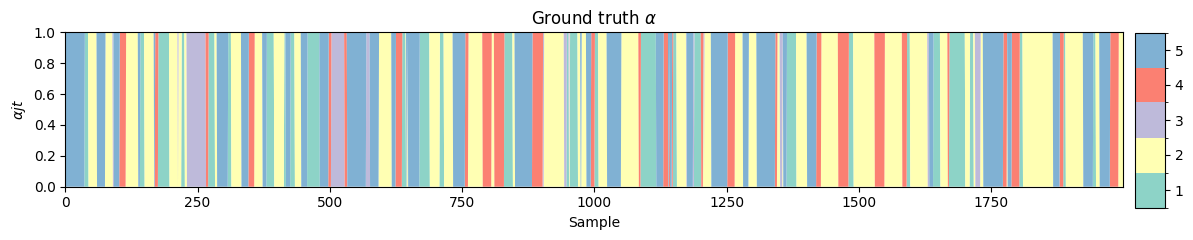

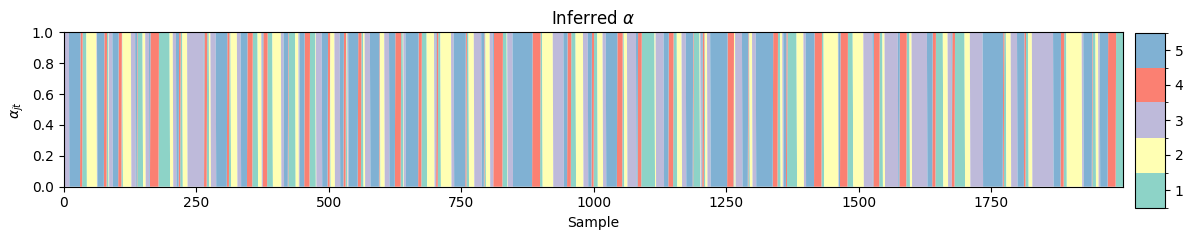

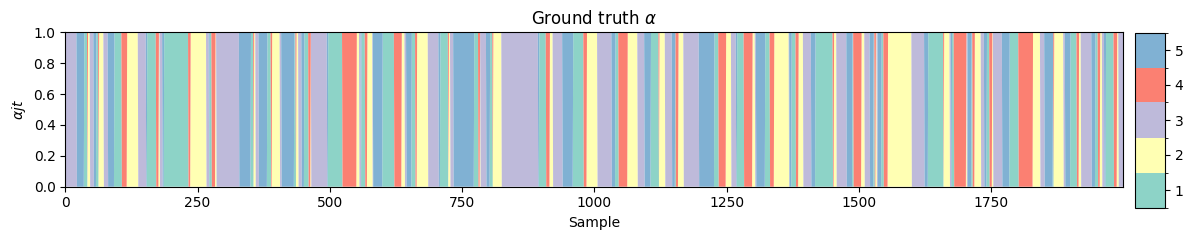

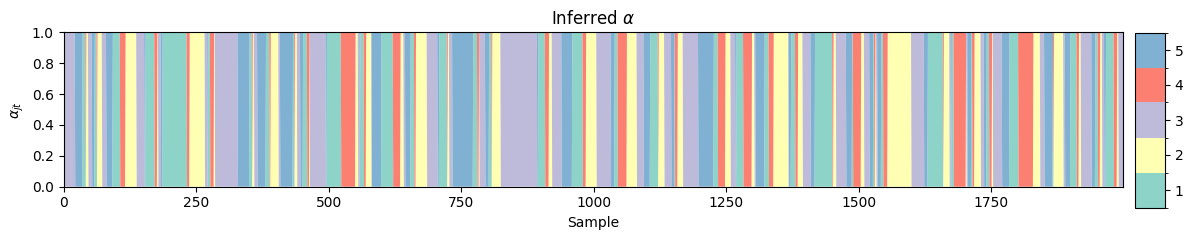

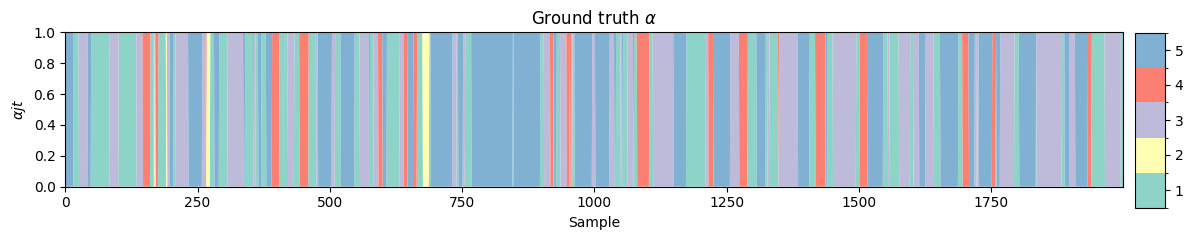

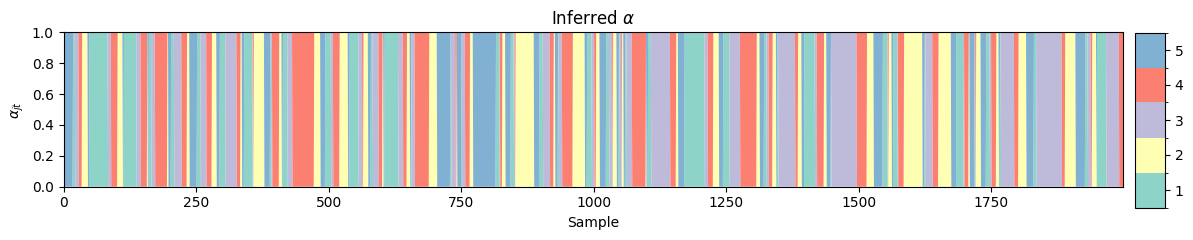

In [ ]:
print("Dice coefficient (Alpha):", dice_alpha)
print("Dice coefficient (Beta):", dice_beta)
print("Dice coefficient (gamma):", dice_gamma)

plotting.plot_alpha(
    inf_stc_alpha,
    n_samples=2000,
    title="Ground truth " + r"$\alpha$",
    y_labels=r"$\alpha{jt}$",
)

plotting.plot_alpha(
    sim_stc_alpha,
    n_samples=2000,
    title="Inferred " + r"$\alpha$",
    y_labels=r"$\alpha_{jt}$",
)

plotting.plot_alpha(
    inf_stc_beta,
    n_samples=2000,
    title="Ground truth " + r"$\alpha$",
    y_labels=r"$\alpha{jt}$",
)

plotting.plot_alpha(
    sim_stc_beta,
    n_samples=2000,
    title="Inferred " + r"$\alpha$",
    y_labels=r"$\alpha_{jt}$",
)


plotting.plot_alpha(
    inf_stc_gamma,
    n_samples=2000,
    title="Ground truth " + r"$\alpha$",
    y_labels=r"$\alpha{jt}$",
)

plotting.plot_alpha(
    sim_stc_gamma,
    n_samples=2000,
    title="Inferred " + r"$\alpha$",
    y_labels=r"$\alpha_{jt}$",
)
# Rng = 15
# Dice coefficient (Alpha): 0.554140625
# Dice coefficient (Beta): 0.9953125
# Dice coefficient (gamma): 0.7173046875

# Rng = 42
# Dice coefficient (Alpha): 0.556328125
# Dice coefficient (Beta): 0.995546875
# Dice coefficient (gamma): 0.68625

# Rn = 63
# Dice coefficient (Alpha): 0.618125
# Dice coefficient (Beta): 0.997265625
# Dice coefficient (gamma): 0.5314453125

In [54]:
sim.means

array([[-2.05026754e-01, -1.00311240e-01,  1.54285079e-02,
         2.35080894e-02, -2.28525531e-01, -3.15390377e-02,
        -1.05149435e-02,  1.59307963e-01,  1.36982887e-01,
        -4.30639149e-02,  1.56559115e-01],
       [-3.43396793e-01,  4.83696877e-01,  1.67306455e-01,
         2.56615500e-02, -7.10318218e-02, -1.40518536e-01,
         2.85101680e-01,  1.89303461e-01, -3.16265242e-02,
        -9.97381378e-02, -9.05089306e-03],
       [-3.98430950e-02, -6.05432367e-02, -4.98890730e-01,
        -7.24086882e-02,  2.55952907e-01,  2.31184475e-01,
         1.35828905e-01, -3.51650775e-03,  1.32223597e-01,
         1.13264508e-01,  3.79011389e-02],
       [ 5.15803798e-02, -1.61628771e-01,  1.09258940e-01,
        -1.31354352e-01, -6.90929897e-02, -3.28781931e-01,
        -3.71548739e-02, -1.13198711e-02,  2.50518288e-01,
        -4.72279791e-04, -4.09010911e-02],
       [-1.88224339e-02, -1.60107230e-01,  1.56009459e-01,
         1.12032854e-01,  8.34633171e-02,  1.01739887e-01,
  

In [1]:
def build_model_configs(n_states, n_channels, sequence_length=100, batch_size=8):
    """Builds and returns a dictionary of model configurations.
    
    Comments indicate the options not used.
    """
    #%% Define model configurations
    config_means = Config(
        n_states=n_states,
        n_channels=n_channels,
        sequence_length=sequence_length,
        learn_means=True,
        learn_covariances=False,
        diagonal_covariances=False,
        learn_trans_prob=True,
        batch_size=batch_size,
        learning_rate=0.01,
        n_epochs=20,
    )

    # config_corrs = Config(
    #     n_states=n_states,
    #     n_channels=n_channels,
    #     sequence_length=sequence_length,
    #     learn_means=False,
    #     learn_covariances=True,
    #     # diagonal_covariances=False,
    #     learn_trans_prob=True,
    #     batch_size=16,
    #     learning_rate=0.01,
    #     n_epochs=20,
    # )

    config_stds = Config(
        n_states=n_states,
        n_channels=n_channels,
        sequence_length=sequence_length,
        learn_means=False,
        learn_covariances=True,
        diagonal_covariances=True,
        learn_trans_prob=True,
        batch_size=batch_size,
        learning_rate=0.01,
        n_epochs=20,
    )

    # It currently isn't possible to learn hmm covariances without variances
    # # 1. Means & Corrs
    # config_means_corrs = Config(
    #     n_states=n_states,
    #     n_channels=n_channels,
    #     sequence_length=sequence_length,
    #     learn_means=True,
    #     learn_covariances=True,  # learn full covariance structure (i.e. correlations)
    #     diagonal_covariances=False,  # we don't restrict to diagonal => using full covariances
    #     learn_trans_prob=True,
    #     batch_size=batch_size,
    #     learning_rate=0.01,
    #     n_epochs=20,
    # )

    # 2. Means & Stds
    config_means_stds = Config(
        n_states=n_states,
        n_channels=n_channels,
        sequence_length=sequence_length,
        learn_means=True,
        learn_covariances=True,  # we want to learn covariances, but restrict to diagonal for stds
        diagonal_covariances=True,
        learn_trans_prob=True,
        batch_size=batch_size,
        learning_rate=0.01,
        n_epochs=20,
    )

    # 3. Stds & Corrs
    config_stds_corrs = Config(
        n_states=n_states,
        n_channels=n_channels,
        sequence_length=sequence_length,
        learn_means=False,
        learn_covariances=True,
        diagonal_covariances=False,  # we want to capture both correlations and then later combine with stds, so full covariances
        learn_trans_prob=True,
        batch_size=batch_size,
        learning_rate=0.01,
        n_epochs=20,
    )

    # 3. All
    config_all = Config(
        n_states=n_states,
        n_channels=n_channels,
        sequence_length=sequence_length,
        learn_means=True,
        learn_covariances=True,
        diagonal_covariances=False,  # we want to capture both correlations and then later combine with stds, so full covariances
        learn_trans_prob=True,
        batch_size=batch_size,
        learning_rate=0.01,
        n_epochs=20,
    )

    # Dictionary mapping model names to their configs
    model_configs = {
        'means': config_means,
        # 'corrs': config_corrs,         # not used
        'stds': config_stds,
        # 'means_corrs': config_means_corrs,  # not used
        'means&stds': config_means_stds,
        'stds&corrs': config_stds_corrs,
        'all': config_all,
    }

    return model_configs

In [ ]:
print("Importing packages")
import os
import random
import numpy as np
import pickle
from osl_dynamics import data, simulation
from osl_dynamics.inference import metrics, modes
from osl_dynamics.models.hmm import Config, Model
from osl_dynamics.simulation import HMM_MVN, MDyn_HMM_MVN
from osl_dynamics.data import Data
from osl_dynamics.utils import plotting


# Set random seed for reproducibility
random.seed(63)

# Create directory for results
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

#%% Simulate data
n_states = 5
n_channels = 11
n_samples = 25600

print("Simulating data")
sim = MDyn_HMM_MVN(
    n_samples=n_samples,
    n_modes=n_states,
    n_channels=n_channels,
    trans_prob="sequence",
    stay_prob=0.9,
    means="random",
    covariances="random",
)

# Retrieve simulated ground truth state time courses
# sim_alpha_stc, sim_beta_stc, sim_gamma_stc = sim.mode_time_course
sim_alpha_stc = sim.mode_time_course

# Retrieve simulated time series for each variant
sim_all_time_series         = sim.time_series
sim_means_time_series       = sim.time_series_means
sim_corrs_time_series       = sim.time_series_corrs
sim_stds_time_series        = sim.time_series_stds
sim_means_corrs_time_series = sim.time_series_means_corrs
sim_means_stds_time_series  = sim.time_series_means_stds
sim_stds_corrs_time_series  = sim.time_series_stds_corrs


# Create Data objects for training for each variant
data_all          = data.Data(sim_all_time_series)  
data_means        = data.Data(sim_means_time_series)
data_corrs        = data.Data(sim_corrs_time_series)
data_stds         = data.Data(sim_stds_time_series)
data_means_corrs  = data.Data(sim_means_corrs_time_series)
data_means_stds   = data.Data(sim_means_stds_time_series)
data_stds_corrs   = data.Data(sim_stds_corrs_time_series)


means = sim.means
corrs = sim.corrs
stds = sim.stds

# Build model configurations dictionary
model_configs = build_model_configs(n_states, n_channels)

# Dictionary mapping dataset names to Data objects
data_dict = {
    'all' : data_all,
    'means': data_means,
    'corrs': data_corrs,
    'stds': data_stds,
    'means&corrs': data_means_corrs,
    'means&stds': data_means_stds,
    'stds&corrs': data_stds_corrs,
}

# Dictionary mapping dataset names to ground truth state time courses
sim_stcs = {
    'all' : sim_alpha_stc,
    'means': sim_alpha_stc,
    'corrs': sim_alpha_stc,
    'stds': sim_alpha_stc,
    'means&corrs': sim_alpha_stc,
    'means&stds': sim_alpha_stc,
    'stds&corrs': sim_alpha_stc,
}

#%% Run models on all datasets and store results
results = {}  # Structure: results[model_name][data_name] = {free_energy, dice, inf_stc, sim_stc}

# Loop over model types
for model_name, config in model_configs.items():
    results[model_name] = {}
    # Loop over dataset types
    for data_name, data in data_dict.items():
        print(f"\nRunning model '{model_name}' on dataset '{data_name}'")
        # Create a new model instance for this combination
        model = Model(config)
        
        # Standardize data (if not already done)
        data.prepare({"standardize": {}})
        
        # Initialization (adjust n_init/n_epochs as needed)
        init_history = model.random_state_time_course_initialization(data, n_init=5, n_epochs=1)
        
        # Full training
        history = model.fit(data)
        
        # Calculate free energy
        free_energy = model.free_energy(data)
        
        # Get inferred state probabilities and compute Viterbi path
        alp = model.get_alpha(data)
        # means, covs = model.get_means_covariances()
        inf_means, inf_stds, inf_corrs = model.get_means_stds_corrs()
        inf_stc = modes.argmax_time_courses(alp)
        
        # Re-order the inferred state time course to match the ground truth
        inf_stc, sim_stc = modes.match_modes(inf_stc, sim_stcs[data_name])
        
        # Calculate dice coefficient comparing inferred vs. simulated state time courses
        dice = metrics.dice_coefficient(inf_stc, sim_stc)
        
        # Save the results for this run
        results[model_name][data_name] = {
            'free_energy': free_energy,
            'dice': dice,
            'means': inf_means,
            'corrs': inf_corrs,
            'stds': inf_stds,
            'inf_stc': inf_stc,
            'sim_stc': sim_stc
        }
        
        print(f"Free energy: {free_energy}")
        print(f"Dice coefficient: {dice}")

# Print summary of all runs
print("\nSummary of all runs:")
for m_name, runs in results.items():
    for d_name, res in runs.items():
        print(f"Model '{m_name}' on dataset '{d_name}': Free energy = {res['free_energy']}, Dice = {res['dice']}")


Simulating data


Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]


Running model 'alpha' on dataset 'alpha'


Standardize:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-11 17:46:52 INFO osl-dynamics [hmm.py:485:random_state_time_course_initialization]: Random state time course initialization
2025-03-11 17:46:52 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 0
2025-03-11 17:46:52 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 2s 154ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6056


2025-03-11 17:46:54 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 1
2025-03-11 17:46:54 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 2s 147ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6054


2025-03-11 17:46:56 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 2
2025-03-11 17:46:56 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 2s 144ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6039


2025-03-11 17:46:59 INFO osl-dynamics [hmm.py:522:random_state_time_course_initialization]: Using initialization 2


Epoch 1/20
4/4 [==============================] - 1s 145ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.5912
Epoch 2/20
4/4 [==============================] - 1s 142ms/step - rho: 0.1866 - lr: 0.0090 - loss: 15.5738
Epoch 3/20
4/4 [==============================] - 1s 142ms/step - rho: 0.1436 - lr: 0.0082 - loss: 15.5580
Epoch 4/20
4/4 [==============================] - 1s 142ms/step - rho: 0.1187 - lr: 0.0074 - loss: 15.5449
Epoch 5/20
4/4 [==============================] - 1s 145ms/step - rho: 0.1022 - lr: 0.0067 - loss: 15.5343
Epoch 6/20
4/4 [==============================] - 1s 146ms/step - rho: 0.0904 - lr: 0.0061 - loss: 15.5263
Epoch 7/20
4/4 [==============================] - 1s 146ms/step - rho: 0.0814 - lr: 0.0055 - loss: 15.5208
Epoch 8/20
4/4 [==============================] - 1s 142ms/step - rho: 0.0743 - lr: 0.0050 - loss: 15.5173
Epoch 9/20
4/4 [==============================] - 1s 143ms/step - rho: 0.0686 - lr: 0.0045 - loss: 15.5150
Epoch 10/20
4/4 [====================

2025-03-11 17:47:12 INFO osl-dynamics [hmm.py:1118:free_energy]: Getting free energy
2025-03-11 17:47:13 INFO osl-dynamics [hmm.py:1311:get_alpha]: Getting alpha


Free energy: 15.58153786504492
Dice coefficient: 0.47359375

Running model 'alpha' on dataset 'beta'


Standardize:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-11 17:47:13 INFO osl-dynamics [hmm.py:485:random_state_time_course_initialization]: Random state time course initialization
2025-03-11 17:47:13 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 0
2025-03-11 17:47:13 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 2s 151ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6054


2025-03-11 17:47:16 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 1
2025-03-11 17:47:16 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 2s 152ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6069


2025-03-11 17:47:18 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 2
2025-03-11 17:47:18 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 2s 154ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6071


2025-03-11 17:47:20 INFO osl-dynamics [hmm.py:522:random_state_time_course_initialization]: Using initialization 0


Epoch 1/20
4/4 [==============================] - 1s 155ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.5970
Epoch 2/20
4/4 [==============================] - 1s 149ms/step - rho: 0.1866 - lr: 0.0090 - loss: 15.5843
Epoch 3/20
4/4 [==============================] - 1s 142ms/step - rho: 0.1436 - lr: 0.0082 - loss: 15.5648
Epoch 4/20
4/4 [==============================] - 1s 146ms/step - rho: 0.1187 - lr: 0.0074 - loss: 15.5420
Epoch 5/20
4/4 [==============================] - 1s 150ms/step - rho: 0.1022 - lr: 0.0067 - loss: 15.5185
Epoch 6/20
4/4 [==============================] - 1s 163ms/step - rho: 0.0904 - lr: 0.0061 - loss: 15.4954
Epoch 7/20
4/4 [==============================] - 1s 149ms/step - rho: 0.0814 - lr: 0.0055 - loss: 15.4731
Epoch 8/20
4/4 [==============================] - 1s 142ms/step - rho: 0.0743 - lr: 0.0050 - loss: 15.4524
Epoch 9/20
4/4 [==============================] - 1s 145ms/step - rho: 0.0686 - lr: 0.0045 - loss: 15.4330
Epoch 10/20
4/4 [====================

2025-03-11 17:47:33 INFO osl-dynamics [hmm.py:1118:free_energy]: Getting free energy
2025-03-11 17:47:33 INFO osl-dynamics [hmm.py:1311:get_alpha]: Getting alpha


Free energy: 15.534079995673736
Dice coefficient: 0.3265625

Running model 'alpha' on dataset 'gamma'


Standardize:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-11 17:47:34 INFO osl-dynamics [hmm.py:485:random_state_time_course_initialization]: Random state time course initialization
2025-03-11 17:47:34 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 0
2025-03-11 17:47:34 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 2s 145ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6077


2025-03-11 17:47:36 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 1
2025-03-11 17:47:36 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 2s 148ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6076


2025-03-11 17:47:38 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 2
2025-03-11 17:47:38 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 2s 145ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6081


2025-03-11 17:47:40 INFO osl-dynamics [hmm.py:522:random_state_time_course_initialization]: Using initialization 1


Epoch 1/20
4/4 [==============================] - 1s 144ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6072
Epoch 2/20
4/4 [==============================] - 1s 145ms/step - rho: 0.1866 - lr: 0.0090 - loss: 15.6072
Epoch 3/20
4/4 [==============================] - 1s 154ms/step - rho: 0.1436 - lr: 0.0082 - loss: 15.6069
Epoch 4/20
4/4 [==============================] - 1s 150ms/step - rho: 0.1187 - lr: 0.0074 - loss: 15.6068
Epoch 5/20
4/4 [==============================] - 1s 146ms/step - rho: 0.1022 - lr: 0.0067 - loss: 15.6065
Epoch 6/20
4/4 [==============================] - 1s 150ms/step - rho: 0.0904 - lr: 0.0061 - loss: 15.6062
Epoch 7/20
4/4 [==============================] - 1s 154ms/step - rho: 0.0814 - lr: 0.0055 - loss: 15.6060
Epoch 8/20
4/4 [==============================] - 1s 383ms/step - rho: 0.0743 - lr: 0.0050 - loss: 15.6058
Epoch 9/20
4/4 [==============================] - 1s 148ms/step - rho: 0.0686 - lr: 0.0045 - loss: 15.6055
Epoch 10/20
4/4 [====================

2025-03-11 17:47:54 INFO osl-dynamics [hmm.py:1118:free_energy]: Getting free energy
2025-03-11 17:47:54 INFO osl-dynamics [hmm.py:1311:get_alpha]: Getting alpha


Free energy: 15.608068970651377
Dice coefficient: 0.21796875

Running model 'beta' on dataset 'alpha'


Standardize:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-11 17:47:55 INFO osl-dynamics [hmm.py:485:random_state_time_course_initialization]: Random state time course initialization
2025-03-11 17:47:55 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 0
2025-03-11 17:47:55 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 3s 153ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6010


2025-03-11 17:47:58 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 1
2025-03-11 17:47:58 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 3s 151ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6018


2025-03-11 17:48:00 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 2
2025-03-11 17:48:00 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 3s 157ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6008


2025-03-11 17:48:03 INFO osl-dynamics [hmm.py:522:random_state_time_course_initialization]: Using initialization 2


Epoch 1/20
4/4 [==============================] - 1s 153ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.5943
Epoch 2/20
4/4 [==============================] - 1s 156ms/step - rho: 0.1866 - lr: 0.0090 - loss: 15.5896
Epoch 3/20
4/4 [==============================] - 1s 150ms/step - rho: 0.1436 - lr: 0.0082 - loss: 15.5823
Epoch 4/20
4/4 [==============================] - 1s 150ms/step - rho: 0.1187 - lr: 0.0074 - loss: 15.5744
Epoch 5/20
4/4 [==============================] - 1s 149ms/step - rho: 0.1022 - lr: 0.0067 - loss: 15.5673
Epoch 6/20
4/4 [==============================] - 1s 145ms/step - rho: 0.0904 - lr: 0.0061 - loss: 15.5612
Epoch 7/20
4/4 [==============================] - 1s 147ms/step - rho: 0.0814 - lr: 0.0055 - loss: 15.5566
Epoch 8/20
4/4 [==============================] - 1s 153ms/step - rho: 0.0743 - lr: 0.0050 - loss: 15.5530
Epoch 9/20
4/4 [==============================] - 1s 147ms/step - rho: 0.0686 - lr: 0.0045 - loss: 15.5509
Epoch 10/20
4/4 [====================

2025-03-11 17:48:16 INFO osl-dynamics [hmm.py:1118:free_energy]: Getting free energy
2025-03-11 17:48:16 INFO osl-dynamics [hmm.py:1311:get_alpha]: Getting alpha


Free energy: 15.596513337278914
Dice coefficient: 0.2292578125

Running model 'beta' on dataset 'beta'


Standardize:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-11 17:48:17 INFO osl-dynamics [hmm.py:485:random_state_time_course_initialization]: Random state time course initialization
2025-03-11 17:48:17 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 0
2025-03-11 17:48:17 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 3s 151ms/step - rho: 0.2853 - lr: 0.0100 - loss: 14.9554


2025-03-11 17:48:20 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 1
2025-03-11 17:48:20 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 2s 148ms/step - rho: 0.2853 - lr: 0.0100 - loss: 14.9386


2025-03-11 17:48:22 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 2
2025-03-11 17:48:22 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 3s 154ms/step - rho: 0.2853 - lr: 0.0100 - loss: 14.9665


2025-03-11 17:48:26 INFO osl-dynamics [hmm.py:522:random_state_time_course_initialization]: Using initialization 1


Epoch 1/20
4/4 [==============================] - 1s 149ms/step - rho: 0.2853 - lr: 0.0100 - loss: 14.6674
Epoch 2/20
4/4 [==============================] - 1s 146ms/step - rho: 0.1866 - lr: 0.0090 - loss: 14.4350
Epoch 3/20
4/4 [==============================] - 1s 152ms/step - rho: 0.1436 - lr: 0.0082 - loss: 14.2074
Epoch 4/20
4/4 [==============================] - 1s 148ms/step - rho: 0.1187 - lr: 0.0074 - loss: 14.0158
Epoch 5/20
4/4 [==============================] - 1s 151ms/step - rho: 0.1022 - lr: 0.0067 - loss: 13.8524
Epoch 6/20
4/4 [==============================] - 1s 146ms/step - rho: 0.0904 - lr: 0.0061 - loss: 13.7054
Epoch 7/20
4/4 [==============================] - 1s 147ms/step - rho: 0.0814 - lr: 0.0055 - loss: 13.5751
Epoch 8/20
4/4 [==============================] - 1s 147ms/step - rho: 0.0743 - lr: 0.0050 - loss: 13.4634
Epoch 9/20
4/4 [==============================] - 1s 148ms/step - rho: 0.0686 - lr: 0.0045 - loss: 13.3674
Epoch 10/20
4/4 [====================

2025-03-11 17:48:38 INFO osl-dynamics [hmm.py:1118:free_energy]: Getting free energy
2025-03-11 17:48:39 INFO osl-dynamics [hmm.py:1311:get_alpha]: Getting alpha


Free energy: 13.144538844541596
Dice coefficient: 0.796875

Running model 'beta' on dataset 'gamma'


Standardize:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-11 17:48:40 INFO osl-dynamics [hmm.py:485:random_state_time_course_initialization]: Random state time course initialization
2025-03-11 17:48:40 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 0
2025-03-11 17:48:40 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 3s 152ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.5906


2025-03-11 17:48:42 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 1
2025-03-11 17:48:42 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 3s 153ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.5970


2025-03-11 17:48:45 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 2
2025-03-11 17:48:45 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 3s 196ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.5915


2025-03-11 17:48:48 INFO osl-dynamics [hmm.py:522:random_state_time_course_initialization]: Using initialization 0


Epoch 1/20
4/4 [==============================] - 1s 168ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.5538
Epoch 2/20
4/4 [==============================] - 1s 151ms/step - rho: 0.1866 - lr: 0.0090 - loss: 15.5155
Epoch 3/20
4/4 [==============================] - 1s 168ms/step - rho: 0.1436 - lr: 0.0082 - loss: 15.4817
Epoch 4/20
4/4 [==============================] - 1s 152ms/step - rho: 0.1187 - lr: 0.0074 - loss: 15.4546
Epoch 5/20
4/4 [==============================] - 1s 197ms/step - rho: 0.1022 - lr: 0.0067 - loss: 15.4322
Epoch 6/20
4/4 [==============================] - 1s 206ms/step - rho: 0.0904 - lr: 0.0061 - loss: 15.4132
Epoch 7/20
4/4 [==============================] - 1s 165ms/step - rho: 0.0814 - lr: 0.0055 - loss: 15.3981
Epoch 8/20
4/4 [==============================] - 1s 166ms/step - rho: 0.0743 - lr: 0.0050 - loss: 15.3860
Epoch 9/20
4/4 [==============================] - 1s 152ms/step - rho: 0.0686 - lr: 0.0045 - loss: 15.3753
Epoch 10/20
4/4 [====================

2025-03-11 17:49:02 INFO osl-dynamics [hmm.py:1118:free_energy]: Getting free energy
2025-03-11 17:49:02 INFO osl-dynamics [hmm.py:1311:get_alpha]: Getting alpha


Free energy: 15.466382325821705
Dice coefficient: 0.5796875

Running model 'gamma' on dataset 'alpha'


Standardize:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-11 17:49:03 INFO osl-dynamics [hmm.py:485:random_state_time_course_initialization]: Random state time course initialization
2025-03-11 17:49:03 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 0
2025-03-11 17:49:03 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 2s 141ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6079


2025-03-11 17:49:05 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 1
2025-03-11 17:49:05 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 3s 409ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6075


2025-03-11 17:49:09 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 2
2025-03-11 17:49:09 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 2s 145ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6079


2025-03-11 17:49:11 INFO osl-dynamics [hmm.py:522:random_state_time_course_initialization]: Using initialization 1


Epoch 1/20
4/4 [==============================] - 1s 141ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6074
Epoch 2/20
4/4 [==============================] - 1s 142ms/step - rho: 0.1866 - lr: 0.0090 - loss: 15.6073
Epoch 3/20
4/4 [==============================] - 1s 149ms/step - rho: 0.1436 - lr: 0.0082 - loss: 15.6072
Epoch 4/20
4/4 [==============================] - 1s 142ms/step - rho: 0.1187 - lr: 0.0074 - loss: 15.6071
Epoch 5/20
4/4 [==============================] - 1s 143ms/step - rho: 0.1022 - lr: 0.0067 - loss: 15.6070
Epoch 6/20
4/4 [==============================] - 1s 144ms/step - rho: 0.0904 - lr: 0.0061 - loss: 15.6069
Epoch 7/20
4/4 [==============================] - 1s 144ms/step - rho: 0.0814 - lr: 0.0055 - loss: 15.6068
Epoch 8/20
4/4 [==============================] - 1s 162ms/step - rho: 0.0743 - lr: 0.0050 - loss: 15.6067
Epoch 9/20
4/4 [==============================] - 1s 147ms/step - rho: 0.0686 - lr: 0.0045 - loss: 15.6065
Epoch 10/20
4/4 [====================

2025-03-11 17:49:24 INFO osl-dynamics [hmm.py:1118:free_energy]: Getting free energy
2025-03-11 17:49:24 INFO osl-dynamics [hmm.py:1311:get_alpha]: Getting alpha


Free energy: 15.608120926415998
Dice coefficient: 0.2187109375

Running model 'gamma' on dataset 'beta'


Standardize:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-11 17:49:25 INFO osl-dynamics [hmm.py:485:random_state_time_course_initialization]: Random state time course initialization
2025-03-11 17:49:25 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 0
2025-03-11 17:49:25 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 3s 152ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6072


2025-03-11 17:49:27 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 1
2025-03-11 17:49:27 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 3s 144ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6061


2025-03-11 17:49:30 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 2
2025-03-11 17:49:30 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 2s 151ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6059


2025-03-11 17:49:32 INFO osl-dynamics [hmm.py:522:random_state_time_course_initialization]: Using initialization 2


Epoch 1/20
4/4 [==============================] - 1s 155ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6006
Epoch 2/20
4/4 [==============================] - 1s 151ms/step - rho: 0.1866 - lr: 0.0090 - loss: 15.5928
Epoch 3/20
4/4 [==============================] - 1s 170ms/step - rho: 0.1436 - lr: 0.0082 - loss: 15.5833
Epoch 4/20
4/4 [==============================] - 1s 154ms/step - rho: 0.1187 - lr: 0.0074 - loss: 15.5727
Epoch 5/20
4/4 [==============================] - 1s 141ms/step - rho: 0.1022 - lr: 0.0067 - loss: 15.5624
Epoch 6/20
4/4 [==============================] - 1s 141ms/step - rho: 0.0904 - lr: 0.0061 - loss: 15.5520
Epoch 7/20
4/4 [==============================] - 1s 139ms/step - rho: 0.0814 - lr: 0.0055 - loss: 15.5421
Epoch 8/20
4/4 [==============================] - 1s 140ms/step - rho: 0.0743 - lr: 0.0050 - loss: 15.5330
Epoch 9/20
4/4 [==============================] - 1s 141ms/step - rho: 0.0686 - lr: 0.0045 - loss: 15.5244
Epoch 10/20
4/4 [====================

2025-03-11 17:49:45 INFO osl-dynamics [hmm.py:1118:free_energy]: Getting free energy
2025-03-11 17:49:45 INFO osl-dynamics [hmm.py:1311:get_alpha]: Getting alpha


Free energy: 15.566271663714888
Dice coefficient: 0.2173828125

Running model 'gamma' on dataset 'gamma'


Standardize:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-11 17:49:46 INFO osl-dynamics [hmm.py:485:random_state_time_course_initialization]: Random state time course initialization
2025-03-11 17:49:46 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 0
2025-03-11 17:49:46 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 2s 141ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6054


2025-03-11 17:49:49 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 1
2025-03-11 17:49:49 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 3s 145ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6006


2025-03-11 17:49:52 INFO osl-dynamics [hmm.py:501:random_state_time_course_initialization]: Initialization 2
2025-03-11 17:49:52 INFO osl-dynamics [hmm.py:1008:set_random_state_time_course_initialization]: Setting random means and covariances


Epoch 1/1
4/4 [==============================] - 2s 143ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.6057


2025-03-11 17:49:55 INFO osl-dynamics [hmm.py:522:random_state_time_course_initialization]: Using initialization 1


Epoch 1/20
4/4 [==============================] - 1s 145ms/step - rho: 0.2853 - lr: 0.0100 - loss: 15.5872
Epoch 2/20
4/4 [==============================] - 1s 142ms/step - rho: 0.1866 - lr: 0.0090 - loss: 15.5699
Epoch 3/20
4/4 [==============================] - 1s 149ms/step - rho: 0.1436 - lr: 0.0082 - loss: 15.5520
Epoch 4/20
4/4 [==============================] - 1s 144ms/step - rho: 0.1187 - lr: 0.0074 - loss: 15.5353
Epoch 5/20
4/4 [==============================] - 1s 140ms/step - rho: 0.1022 - lr: 0.0067 - loss: 15.5208
Epoch 6/20
4/4 [==============================] - 1s 140ms/step - rho: 0.0904 - lr: 0.0061 - loss: 15.5080
Epoch 7/20
4/4 [==============================] - 1s 142ms/step - rho: 0.0814 - lr: 0.0055 - loss: 15.4973
Epoch 8/20
4/4 [==============================] - 1s 148ms/step - rho: 0.0743 - lr: 0.0050 - loss: 15.4877
Epoch 9/20
4/4 [==============================] - 1s 143ms/step - rho: 0.0686 - lr: 0.0045 - loss: 15.4797
Epoch 10/20
4/4 [====================

2025-03-11 17:50:07 INFO osl-dynamics [hmm.py:1118:free_energy]: Getting free energy
2025-03-11 17:50:07 INFO osl-dynamics [hmm.py:1311:get_alpha]: Getting alpha


Free energy: 15.515351181773196
Dice coefficient: 0.52828125

Summary of all runs:
Model 'alpha' on dataset 'alpha': Free energy = 15.58153786504492, Dice = 0.47359375
Model 'alpha' on dataset 'beta': Free energy = 15.534079995673736, Dice = 0.3265625
Model 'alpha' on dataset 'gamma': Free energy = 15.608068970651377, Dice = 0.21796875
Model 'beta' on dataset 'alpha': Free energy = 15.596513337278914, Dice = 0.2292578125
Model 'beta' on dataset 'beta': Free energy = 13.144538844541596, Dice = 0.796875
Model 'beta' on dataset 'gamma': Free energy = 15.466382325821705, Dice = 0.5796875
Model 'gamma' on dataset 'alpha': Free energy = 15.608120926415998, Dice = 0.2187109375
Model 'gamma' on dataset 'beta': Free energy = 15.566271663714888, Dice = 0.2173828125
Model 'gamma' on dataset 'gamma': Free energy = 15.515351181773196, Dice = 0.52828125


/gpfs3/well/win-fmrib-analysis/users/psz102/git_repos/osl-dynamics/osl_dynamics/utils/plotting.py:1768: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1081074/2886176156.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


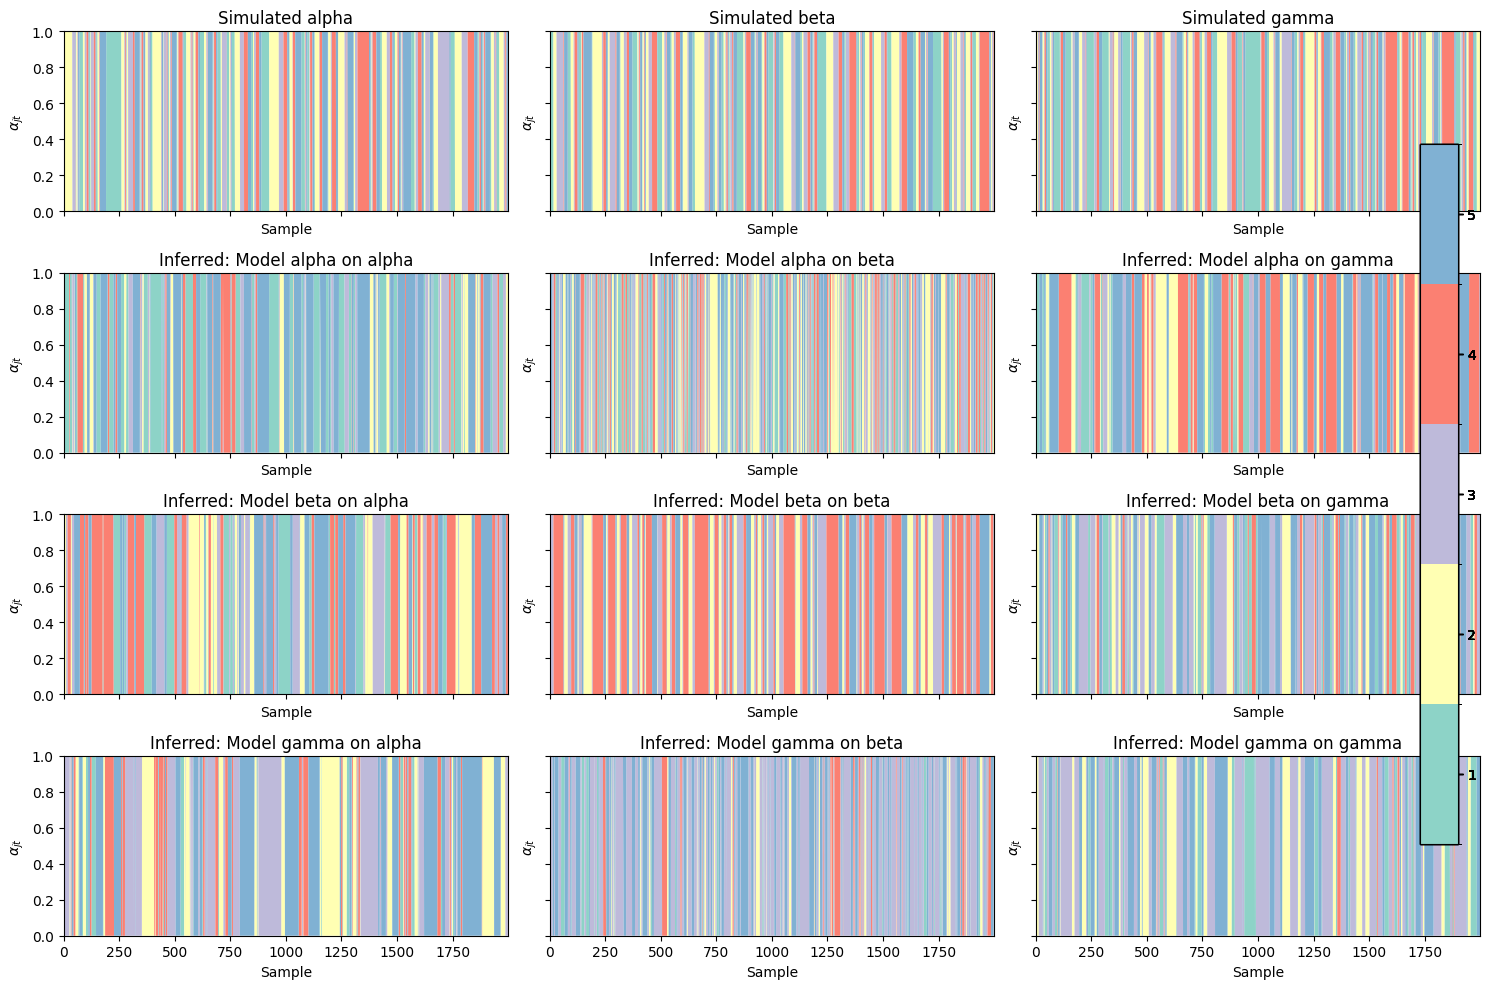

In [36]:
import matplotlib.pyplot as plt
from osl_dynamics.utils import plotting  # or however you import your plotting module

# Define the keys for your simulated and inferred state time courses
data_names = ['alpha', 'beta', 'gamma']
model_names = ['alpha', 'beta', 'gamma']

# Create a grid with 4 rows and 3 columns
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 10), sharex=True, sharey=True)

# Row 0: Plot simulated ground truth state time courses
for j, d_name in enumerate(data_names):
    ax = axs[0, j]
    plotting.plot_alpha(
        sim_stcs[d_name],       # simulated state time course for this dataset
        n_samples=2000,
        title=f"Simulated {d_name}",
        y_labels=r"$\alpha_{jt}$",
        axes=[ax]
    )

# Row 1: Plot inferred state time courses from model 'alpha'
for j, d_name in enumerate(data_names):
    ax = axs[1, j]
    plotting.plot_alpha(
        results['alpha'][d_name]['inf_stc'],  # inferred stc from model alpha on dataset d_name
        n_samples=2000,
        title=f"Inferred: Model alpha on {d_name}",
        y_labels=r"$\alpha_{jt}$",
        axes=[ax]
    )

# Row 2: Plot inferred state time courses from model 'beta'
for j, d_name in enumerate(data_names):
    ax = axs[2, j]
    plotting.plot_alpha(
        results['beta'][d_name]['inf_stc'],  # inferred stc from model beta on dataset d_name
        n_samples=2000,
        title=f"Inferred: Model beta on {d_name}",
        y_labels=r"$\alpha_{jt}$",
        axes=[ax]
    )

# Row 3: Plot inferred state time courses from model 'gamma'
for j, d_name in enumerate(data_names):
    ax = axs[3, j]
    plotting.plot_alpha(
        results['gamma'][d_name]['inf_stc'],  # inferred stc from model gamma on dataset d_name
        n_samples=2000,
        title=f"Inferred: Model gamma on {d_name}",
        y_labels=r"$\alpha_{jt}$",
        axes=[ax]
    )

plt.tight_layout()
plt.show()


Grid of Dice Coefficients (rows: simulated data, columns: model):
          alpha      beta     gamma
alpha  0.473594  0.229258  0.218711
beta   0.326562  0.796875  0.217383
gamma  0.217969  0.579688  0.528281


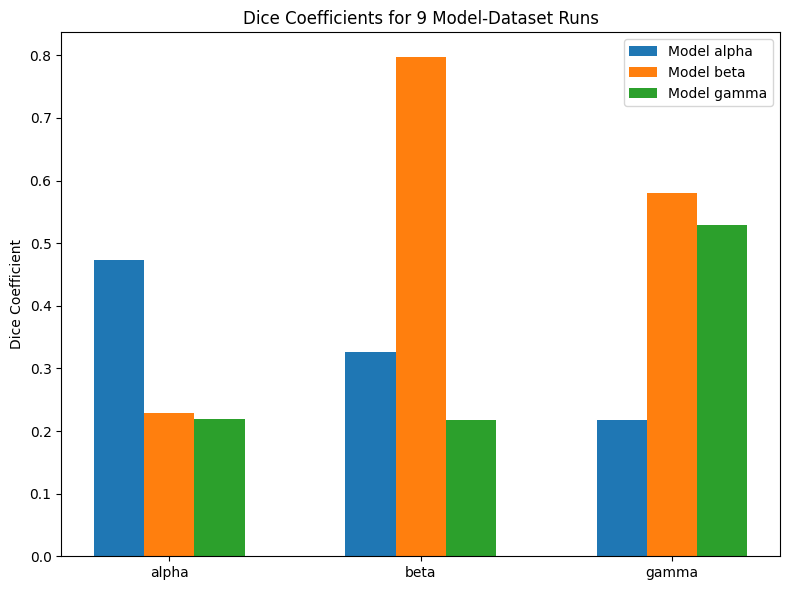

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume results is already defined from the analysis code, and keys are:
# model_names = ['alpha', 'beta', 'gamma'] and data_names = ['alpha', 'beta', 'gamma']
model_names = ['alpha', 'beta', 'gamma']
data_names = ['alpha', 'beta', 'gamma']

# Create a DataFrame with rows = simulated dataset type, columns = model type
dice_grid = pd.DataFrame({
    m_name: [results[m_name][d_name]['dice'] for d_name in data_names]
    for m_name in model_names
}, index=data_names)

print("Grid of Dice Coefficients (rows: simulated data, columns: model):")
print(dice_grid)

#%% Plot a grouped bar chart of the dice coefficients
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.2
x = np.arange(len(data_names))  # one tick per simulated dataset type

# Loop over each model to create its bars
for i, m_name in enumerate(model_names):
    dice_values = [results[m_name][d_name]['dice'] for d_name in data_names]
    ax.bar(x + i * bar_width, dice_values, width=bar_width, label=f"Model {m_name}")

# Set x-axis ticks and labels
ax.set_xticks(x + bar_width)
ax.set_xticklabels(data_names)
ax.set_ylabel("Dice Coefficient")
ax.set_title("Dice Coefficients for 9 Model-Dataset Runs")
ax.legend()

plt.tight_layout()
plt.show()


/tmp/ipykernel_1081074/1053893291.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


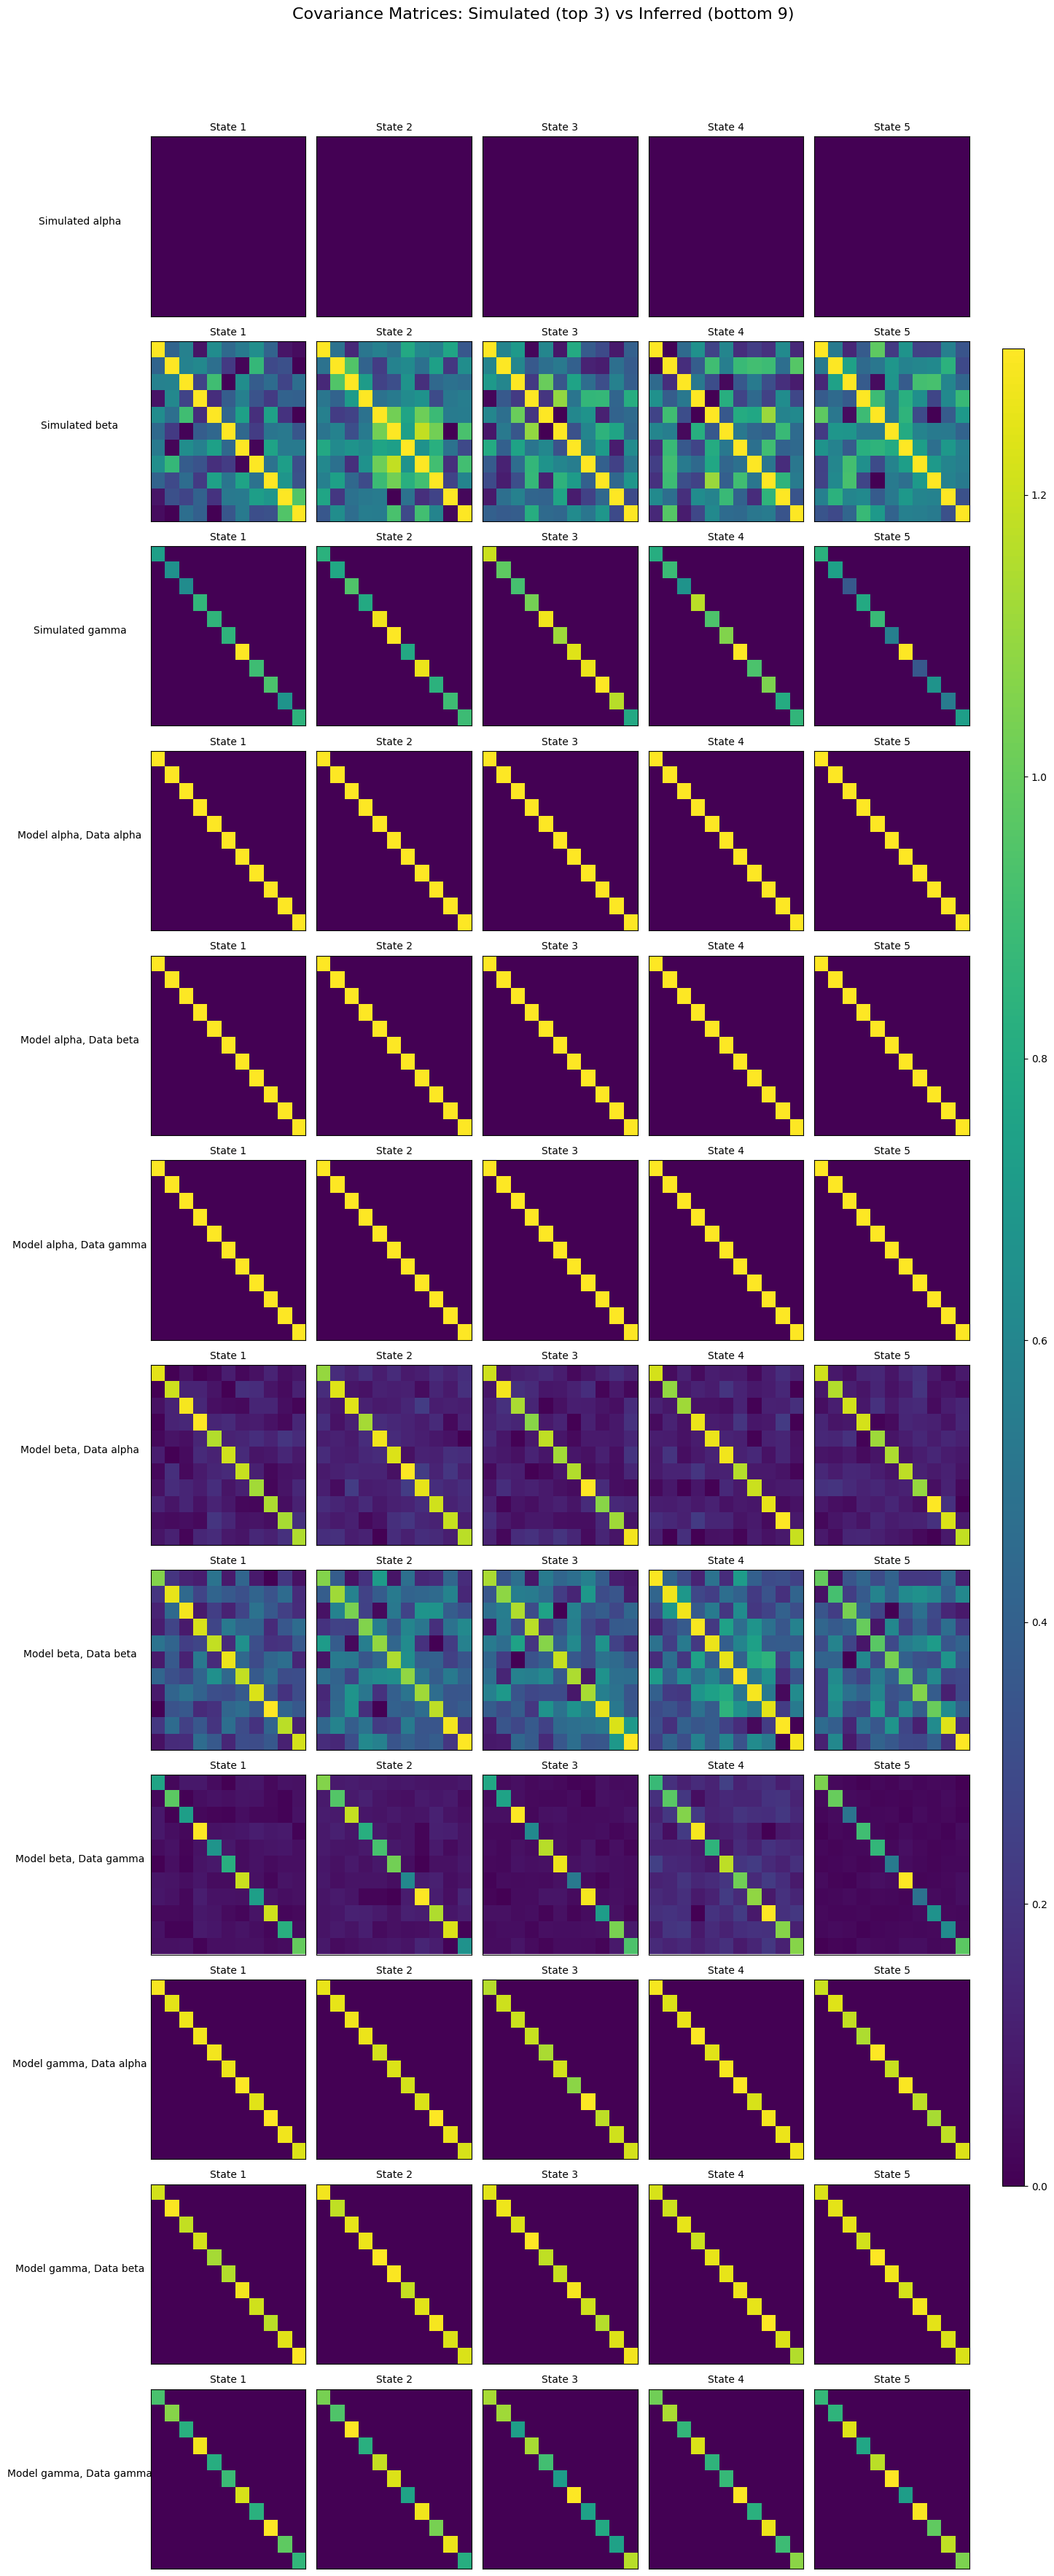

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to convert a state_params dictionary into an array of covariance matrices.
def dict_to_array_covs(state_params, n_states=5):
    covs = []
    for state in range(n_states):
        covs.append(state_params[state]['sigma'])
    return np.array(covs)  # shape: [n_states, n_channels, n_channels]

# --- Prepare simulated covariance matrices ---
sim_run_labels = []
sim_covs_list = []

# These variables should be assigned earlier:
#   state_params_alpha = sim.state_params_alpha
#   state_params_beta  = sim.state_params_beta
#   state_params_gamma = sim.state_params_gamma

sim_run_labels.append("Simulated alpha")
sim_covs_list.append(np.zeros_like(corrs))
sim_run_labels.append("Simulated beta")
sim_covs_list.append(corrs)
sim_run_labels.append("Simulated gamma")
std_array =  np.zeros_like(corrs)
for j in range(5):
    np.fill_diagonal(std_array[j], stds[j])
sim_covs_list.append(std_array)

# --- Prepare inferred covariance matrices (from the 9 runs) ---
inference_run_labels = []
inference_covs_list = []

# We assume that your results dictionary has, for each run, an entry 'covs'
# with shape [5, 11, 11].
for model_name in model_configs.keys():
    for data_name in data_dict.keys():
        run_label = f"Model {model_name}, Data {data_name}"
        covs = results[model_name][data_name]['covs']
        inference_run_labels.append(run_label)
        inference_covs_list.append(covs)

# Combine simulation and inference runs
all_run_labels = sim_run_labels + inference_run_labels  # total should be 3 + 9 = 12 runs
all_covs_list = sim_covs_list + inference_covs_list

n_runs = len(all_covs_list)  # should be 12
n_states = 5  # number of states, hence 5 covariance matrices per run

# Create a grid: 12 rows, 5 columns
fig, axs = plt.subplots(nrows=n_runs, ncols=n_states, figsize=(15, 3 * n_runs))

# Loop over each run (each row) and plot each state's covariance matrix
for i, (label, cov_matrices) in enumerate(zip(all_run_labels, all_covs_list)):
    for j in range(n_states):
        ax = axs[i, j]
        # Plot the j-th covariance matrix (11x11)
        im = ax.imshow(cov_matrices[j], cmap="viridis", aspect="auto")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"State {j+1}", fontsize=10)
    # Label the leftmost subplot of each row with the run label
    axs[i, 0].set_ylabel(label, rotation=0, labelpad=70, fontsize=10)

# Add a common colorbar for the entire figure
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle("Covariance Matrices: Simulated (top 3) vs Inferred (bottom 9)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


In [17]:
import numpy as np

def dict_to_array_means(state_params, n_states=5):
    """Convert a state_params dictionary into a 2D array of means.
    
    Parameters
    ----------
    state_params : dict
        Dictionary where each key is a state index (0, 1, …, n_states-1) 
        and each value is a dictionary with a key 'mu' for the mean vector.
    n_states : int, optional
        Number of states. Default is 5.
    
    Returns
    -------
    means_array : np.ndarray
        Array of shape (n_states, n_channels) containing the mean vectors.
    """
    means = []
    for state in range(n_states):
        means.append(state_params[state]['mu'])
    return np.array(means)


/tmp/ipykernel_1081074/222568829.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 0.95])


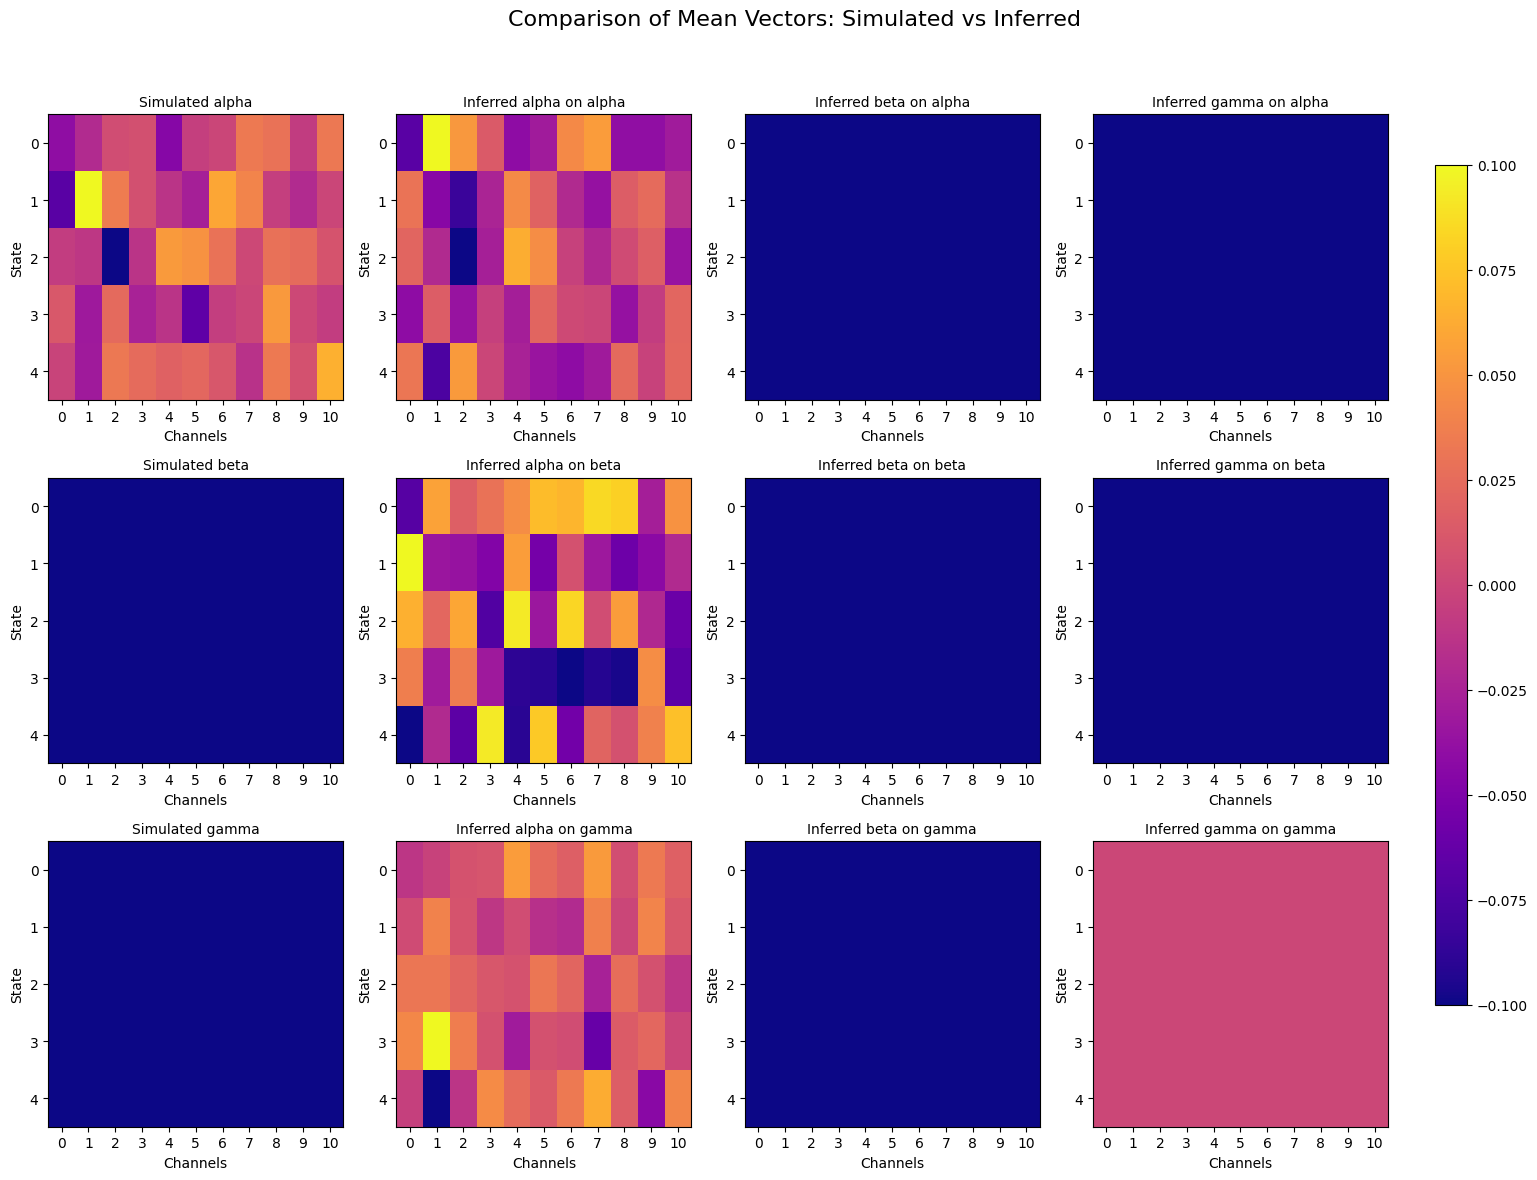

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Define the datasets and model names (order matters)
datasets = ['alpha', 'beta', 'gamma']
models = ['alpha', 'beta', 'gamma']

# Prepare a dictionary for simulated means per dataset:
# For alpha, use the actual simulated means.
sim_means['alpha'] =sim.means  # shape (5, 11)
# For beta and gamma, use a zeros array with the same shape.
sim_means['beta']  = np.zeros_like(means)
sim_means['gamma'] = np.zeros_like(means)

# Prepare a dictionary for inferred means:
# inferred_means[dataset][model] = array of shape (5, 11)
inferred_means = {}
for dataset in datasets:
    inferred_means[dataset] = {}
    for model in models:
        inferred_means[dataset][model] = results[model][dataset]['means']

# Create a grid: 3 rows (one per dataset) x 4 columns (1 simulated + 3 inferred)
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

for i, dataset in enumerate(datasets):
    # Column 0: Simulated means for this dataset
    ax = axs[i, 0]
    im = ax.imshow(sim_means[dataset], cmap="plasma", aspect="auto")
    ax.set_title(f"Simulated {dataset}", fontsize=10)
    ax.set_xlabel("Channels")
    ax.set_ylabel("State")
    ax.set_xticks(range(sim_means[dataset].shape[1]))
    ax.set_yticks(range(sim_means[dataset].shape[0]))
    
    # Columns 1-3: Inferred means for each model for this dataset
    for j, model in enumerate(models):
        ax = axs[i, j+1]
        im = ax.imshow(inferred_means[dataset][model], cmap="plasma", aspect="auto")
        ax.set_title(f"Inferred {model} on {dataset}", fontsize=10)
        ax.set_xlabel("Channels")
        ax.set_ylabel("State")
        ax.set_xticks(range(inferred_means[dataset][model].shape[1]))
        ax.set_yticks(range(inferred_means[dataset][model].shape[0]))

# Add a single common colorbar for all subplots
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle("Comparison of Mean Vectors: Simulated vs Inferred", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.88, 0.95])
plt.show()


In [53]:
means

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [46]:
corrs[0]

array([[ 1.00000000e+00, -1.82077866e-02,  1.58359195e-01,
        -4.18239853e-01,  2.30906908e-01,  1.08932596e-02,
         1.10390499e-01,  2.41185102e-01, -2.48751802e-02,
        -4.12776394e-01, -4.49601645e-01],
       [-1.82077866e-02,  1.00000000e+00,  1.67150671e-01,
         1.99468940e-01,  4.65590895e-02, -2.43184459e-01,
        -4.76632482e-01,  4.98067775e-01, -1.67032418e-01,
        -1.33647216e-01, -4.88987124e-01],
       [ 1.58359195e-01,  1.67150671e-01,  1.00000000e+00,
        -1.96130470e-01,  5.40681960e-01, -4.86104919e-01,
         2.36515412e-01, -6.55395981e-02,  3.01437745e-02,
        -1.94905302e-01,  4.31245558e-02],
       [-4.18239853e-01,  1.99468940e-01, -1.96130470e-01,
         1.00000000e+00, -3.03015665e-01, -5.54766642e-02,
         1.54995368e-01, -1.16618836e-01, -2.43575626e-01,
        -2.66888801e-02, -3.97326033e-02],
       [ 2.30906908e-01,  4.65590895e-02,  5.40681960e-01,
        -3.03015665e-01,  1.00000000e+00,  2.81569777e-04,
  